# Finding limit cycles

This notebook demonstrates an advanced use case of automatic differentiation---finding limit cycles.  This type of analysis comes up in finding periodic orbits of dynamical systems, for example, periodic gaits for walking robots.

### Limit cycles
One of the intriguing phenomena in the study of nonlinear dynamical systems is the presence of limit cycles. A limit cycle can be formally defined as a closed orbit in the phase space that is an isolated solution of the system's differential equations. This means there are no other closed orbits nearby. Stability of a limit cycle can be determined by analyzing the behavior of trajectories near the cycle; if trajectories approach the cycle, it is considered stable (attracting), and if they move away, it is considered unstable (repelling).

### Optimization strategy for finding limit cycles

Consider a dynamical system of the form:

$$ \dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \boldsymbol\theta), $$

where $\mathbf{x}$ is the state vector, $\boldsymbol\theta$ is the vector of system parameters, and $\mathbf{f}$ is a vector field representing model dynamics. The goal is to find a limit cycle of the system, which is a periodic orbit. A common approach to this problem is to use optimization algorithms to find a periodic orbit of the system. The idea is to minimize the distance between the state of the system at time $t$ and the state at time $t+T$, where $T$ is the period of the limit cycle orbit. Since the period $T$ is unknown, it is also treated as an optimization variable. The optimization problem can then be formulated as:

\begin{align}
\min_{\mathbf{x}_0,\, T} & \quad J({\mathbf{x}_0,\, T}) \\
\text{with, }  & \quad  J = \left\| \mathbf{x}(T; \mathbf{x}_0 ,\boldsymbol\theta) - \mathbf{x}_0 \right\|,
\end{align}

where $\mathbf{x}(T; \mathbf{x}_0 ,\boldsymbol\theta)$ is the state at $t=T$ when the system with parameters $\boldsymbol\theta$ starts from $\mathbf{x}_0$ at $t=0$.

With automatic differentiation available in Collimator, taking gradients of $J$ with respect to the optimization variables is quite convenient for optimization.

### Stability of limit cycles

One of the key questions in the study of limit cycles is their stability. The stability of a limit cycle can be determined by analyzing the behavior of trajectories near the cycle. If trajectories approach the cycle, it is considered stable (attracting), and if they move away, it is considered unstable (repelling). A common approach to determining stability is Floquet theory, which involves linearizing the system around the limit cycle and analyzing the eigenvalues of the resulting monodromy matrix. The Floquet multipliers are the eigenvalues of the monodromy matrix, and they determine the stability of the limit cycle. If all Floquet multipliers have magnitude less than 1, the limit cycle is stable, and if any of them have magnitude greater than 1, the limit cycle is unstable.

The Monodromy matrix is defined as the solution of the following variational equation:

$$ \delta \mathbf{x}(T) = \mathbf{M}\, \delta \mathbf{x}(0), $$
where $\delta \mathbf{x}(t)$ is the deviation of the state from the limit cycle at time $t$, and $\mathbf{M}$ is the Monodromy matrix. The Monodromy matrix can be computed by integrating the variational equation along the limit cycle.

$$ \dot{\mathbf{M}} = \mathbf{A}(t)\, \mathbf{M}, \qquad \text{with } \mathbf{M}(t\!=\!0) = \mathbf{I},$$

where $\mathbf{A}(t)$ is the Jacobian matrix ${\partial \mathbf{f}}/{\partial \mathbf{x}} $ of the system evaluated along the limit cycle, and $\mathbf{M}$ is the Monodromy matrix. The Floquet multipliers are then the eigenvalues of the Monodromy matrix.

Alternatively, if the forward map, i.e a map from $\mathbf{x}(t)$ to $\mathbf{x}(t+T)$, is available, the Monodromy matrix can be computed as the jacobian:

$$ \mathbf{M} = \frac{\partial\, \mathbf{x}(t+T)}{\partial \mathbf{x}(t)}. $$

This latter approach is adopted in this notebook. In what follows, we demonstrate how to find the limit cycles and analyze their stability for a number of systems.

In [1]:
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from cyipopt import minimize_ipopt  # NOTE: requires IPOPT to be installed

import collimator
from collimator.simulation import SimulatorOptions
from collimator.models import VanDerPol, RimlessWheel, CompassGait

## 1. Van der Pol oscillator

The Van der Pol oscillator is a nonlinear oscillator with damping. It is described by the following second-order differential equation:

\begin{align}
\dot{x} & = y, \\
\dot{y} & = \mu (1 - x^2) y - x,
\end{align}
where $\mu$ is the damping parameter. The Van der Pol oscillator exhibits limit cycle behavior for certain values of $\mu$. We will demonstrate how to find the limit cycle and analyze its stability using the Floquet multipliers.

To see the implementaion of the Van der Pol system in Collimator please see `collimator/models/van_der_pol.py`

### Stable limit cycle

We first find the limit cycle by solving the optimization problem discussed above. We first define a function `shoot`, that can compute $J$ as a function of $\mathbf{x}_0$ and $T$.

In [2]:
model = VanDerPol(mu=1.0)  # Stable case
context = model.create_context()

Initialized callback VanDerPol(system_id=1, name=..., ui_id=None, parent=None):VanDerPol(system_id=1, name=..., ui_id=None, parent=None)_ode with prereqs [1, 2, 8]
Initialized callback VanDerPol(system_id=1, name=..., ui_id=None, parent=None):y_0 with prereqs [2]


In [3]:
shoot_options = SimulatorOptions(
    enable_autodiff=True,
    max_major_steps=100,
    rtol=1e-12,
    atol=1e-14,
)


def shoot(model, context, unflatten, vec):
    x0, tf = unflatten(vec)  # tf = T in the math notation in the text
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, tf), options=shoot_options)
    xf = results.context.continuous_state
    return jnp.linalg.norm(xf - x0) ** 2


# initial guesses for the optimization problem
x0 = jnp.array([1.0, 0.0])
tf0 = 7.0

vec, unflatten = ravel_pytree((x0, tf0))

# evaluate teh function for the initial guesses
shoot(model, context, unflatten, vec)

Array(0.93392717, dtype=float64)

Next, we use a `scipy` minimization routine with `BFGS` method to minimize $J$. With automatic differentiation, we can automatically compute the Jacobian of the objective $J$ for optimization.

In [4]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
print(res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.370484242351404e-13
        x: [ 1.594e+00 -7.263e-01  6.663e+00]
      nit: 6
      jac: [-2.278e-07  3.487e-07 -7.143e-07]
 hess_inv: [[ 8.276e-01  2.341e-01  6.209e-02]
            [ 2.341e-01  6.778e-01 -6.301e-02]
            [ 6.209e-02 -6.301e-02  7.033e-01]]
     nfev: 7
     njev: 7


We can now simulate the system with the found limit cycle and verify that the solution is indeed periodic.

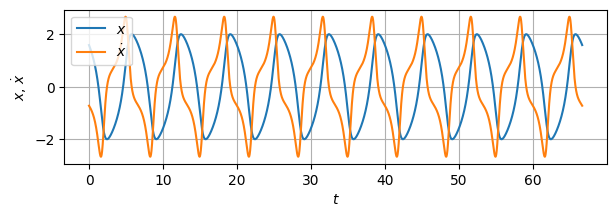

In [5]:
context = model.create_context()
context = context.with_continuous_state(x_opt)

recorded_signals = {"x": model.output_ports[0]}

options = SimulatorOptions(
    rtol=1e-12,
    atol=1e-14,
    max_minor_step_size=0.01,
    max_major_steps=1000,
)

results = collimator.simulate(
    model,
    context,
    (0.0, 10 * tf_opt),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["x"]

plt.figure(figsize=(7, 2))
plt.plot(t, x[:, 0], label="$x$")
plt.plot(t, x[:, 1], label=r"$\dot{x}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$x$, $\dot{x}$")
plt.grid()
plt.show()

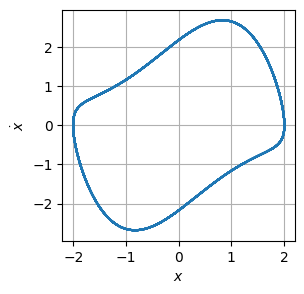

In [6]:
# Show phase portrait
plt.figure(figsize=(3, 3))
plt.plot(x[:, 0], x[:, 1])
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.grid()
plt.show()

### Floquet analysis

For stability analysis, we can now create a forward map (from $\mathbf{x}(t\!=0)$ to $\mathbf{x}(t\!=T)$. Then, we can compute the Jacobian of this forward map, which is the Monodromy matrix. The eigen values of the Monodoromy matrix would provide us the Floquet multipliers.

In [7]:
def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


print(x_opt)
forward_map(model, context, tf_opt, x_opt)

[ 1.59422695 -0.72631635]


Array([ 1.59422744, -0.72631634], dtype=float64)

In [8]:
func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
M = jax.jacrev(func)(x_opt)

floquet_multiploiers = np.linalg.eigvals(M)
print(f"{floquet_multiploiers=}")

floquet_multiploiers=array([9.99999672e-01, 8.59696341e-04])


We find that the magnitude of all the Floquet multipliers are less than 1, indicating that the limit cycle is stable.

## Optimization with IPOPT

We can use an external optimizer such as `IPOPT`. Below we show how to perform the identical optimization as above to find the limit cycle with IPOPT, while including bounds constraints on the optimization variables.

In [9]:
func = jax.jit(partial(shoot, model, context, unflatten))
jac = jax.grad(func)

# Solve the problem using ipopt minimize
bounds = [
    (-2.0, 2.0),  # bounds on x
    (-2.0, 2.0),  # bounds on y = dx/dt
    (6.0, 8.0),  # bounds on the limit cycle period
]
ipopt_options = {
    "tol": 1e-8,
    "max_iter": 1000,
}
res = minimize_ipopt(func, x0=vec, jac=jac, bounds=bounds, options=ipopt_options)
x_opt, tf_opt = unflatten(res.x)
print(res)
print(x_opt, tf_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 6.921423912600132e-18
       x: [ 1.506e+00 -7.837e-01  6.663e+00]
     nit: 6
    info:     status: 0
                   x: [ 1.506e+00 -7.837e-01  6.663e+00]
                   g: []
             obj_val: 6.921423912600132e-18
              mult_g: []
            mult_x_L: [ 2.854e-12  8.189e-12  1.502e-11]
            mult_x_U: [ 2.016e-11  3.598e-12  7.495e-12]
          status_msg: b'Algorithm terminated successfully at a l

# 2. Rimless wheel

A Rimless wheel is a simplified version of a "passive dynamic walker" robot.  It is a wheel with spokes but no rim that "walks" down a ramp. We refer the reader to See 4.2.1 of [underactuated robotics](https://underactuated.csail.mit.edu/simple_legs.html#section2) for details of the model. For implementation in Collimator please see `collimator/models/rimless_wheel.py`.  

In what follows, we demonstrate how Collimator can differentiate through a hybrid system with guards and reset events to find a periodic gait.

In [10]:
model = RimlessWheel()
context = model.create_context()

Initialized callback RimlessWheel_2_:RimlessWheel_2__ode with prereqs [1, 2, 8]
Initialized callback RimlessWheel_2_:y_0 with prereqs [2]
Initialized callback RimlessWheel_2_:y_1 with prereqs [8]


Let's first simulate and visualise the model trajectory from an arbitarry initial contision.

LeafState(xc=[-0.18699956  0.6234898 ], xd=0.8677674782351162)


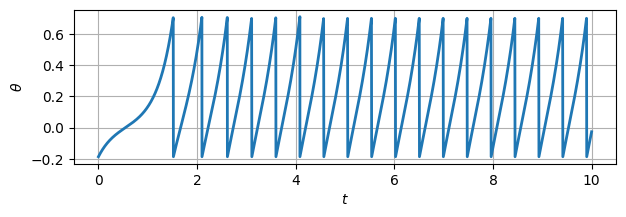

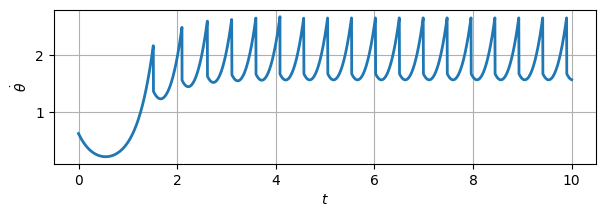

In [11]:
# Generate a valid initial condition using the reset map.
context = context.with_continuous_state(jnp.array([0.0, 1.0]))
context = context.with_state(
    model.downhill_reset(0.0, context.state, **context.parameters)
)
print(context.state)

# Note we want to limit the major step length here to avoid skipping over the collisions
options = SimulatorOptions(
    max_major_step_length=1.0,
    max_major_steps=500,
    atol=1e-14,
    rtol=1e-12,
)
recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
}
results = collimator.simulate(
    model, context, (0.0, 10.0), options=options, recorded_signals=recorded_signals
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 0], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta$")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 1], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.grid()
plt.show()

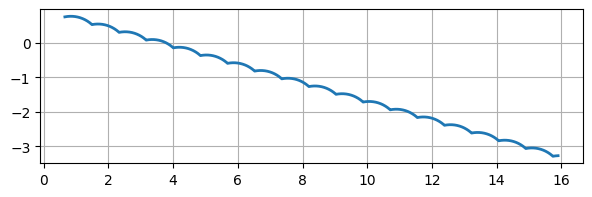

In [12]:
t = results.time
xc = results.outputs["xc"]
toe = results.outputs["toe"]
p = results.context.parameters
model.plot_trajectory(xc, toe, p)

In the $(\theta, \dot{\theta})$ phase plane, the dynamics approach a stable limit cycle

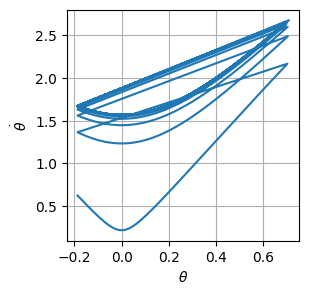

In [13]:
plt.figure(figsize=(3, 3))
plt.plot(x[:, 0], x[:, 1])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\dot{\theta}$")
plt.grid()
plt.show()

In [14]:
try:
    # NOTE: You need IPython and ffmpeg installed to create the animation
    # also may need to point to your local ffmpeg path: `which ffmpeg`
    plt.rcParams["animation.ffmpeg_path"] = "/usr/local/bin/ffmpeg"
    model.animate(t, xc, toe, p, xlim=(-1, 10), ylim=(-2.5, 2.0), ramp_color="k")

except:
    print(
        "Could not create animation.  Make sure ffmpeg is installed and available to matplotlib."
    )

#### Finding limit cycles
As with the Van der Pol oscillator, we now use a simple shooting method to find a periodic "gait"

In [15]:
model = RimlessWheel()
context = model.create_context()

Initialized callback RimlessWheel_3_:RimlessWheel_3__ode with prereqs [1, 2, 8]
Initialized callback RimlessWheel_3_:y_0 with prereqs [2]
Initialized callback RimlessWheel_3_:y_1 with prereqs [8]


In [16]:
# Define a function to compute the difference between the final and initial state


def shoot(model, context, unflatten, vec):
    x0, tf = unflatten(vec)
    context = context.with_continuous_state(x0)
    context = context.with_discrete_state(0.0)

    # Run simulation
    options = SimulatorOptions(
        enable_autodiff=True,
        max_major_step_length=1.0,
        max_major_steps=300,
        atol=1e-14,
        rtol=1e-12,
    )
    results = collimator.simulate(model, context, (0.0, tf), options=options)
    xf = results.context.continuous_state
    return jnp.linalg.norm(xf - x0) ** 2


x0 = jnp.array([0.0, 2.0])
tf0 = 0.5
vec, unflatten = ravel_pytree((x0, tf0))
shoot(model, context, unflatten, vec)

Array(0.05826542, dtype=float64)

In [17]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.578834528821586e-12
        x: [ 2.851e-01  1.803e+00  4.845e-01]
      nit: 6
      jac: [-1.075e-06  7.025e-07  7.884e-06]
 hess_inv: [[ 1.189e+00 -1.250e-01  6.636e-03]
            [-1.250e-01  1.083e+00 -7.519e-03]
            [ 6.636e-03 -7.519e-03  4.308e-02]]
     nfev: 8
     njev: 8

Next, we can simulate the system with the found periodic solution.

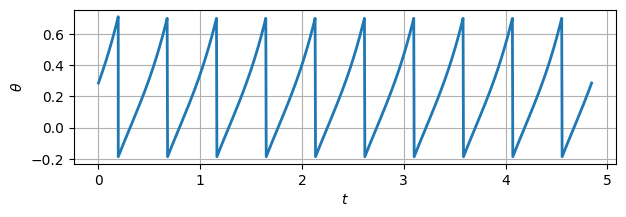

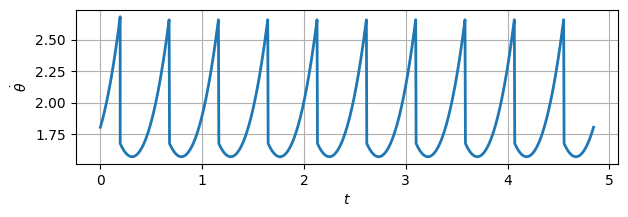

In [18]:
# Note we want to limit the major step length here to avoid skipping over the collision

options = SimulatorOptions(
    max_major_step_length=1.0,
    max_major_steps=300,
    atol=1e-14,
    rtol=1e-12,
)
context = context.with_continuous_state(x_opt)
context = context.with_discrete_state(0.0)

recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
}
results = collimator.simulate(
    model,
    context,
    (0.0, 10 * tf_opt),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 0], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta$")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 1], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.grid()
plt.show()

# model.plot(xf, t_eval)

The trajectory now starts and stays on the limit cycle. We can also visualize the trajectory in the phase space.

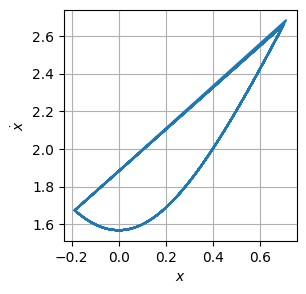

In [19]:
# Show phase portrait
plt.figure(figsize=(3, 3))
plt.plot(x[:, 0], x[:, 1])
plt.xlabel("$x$")
plt.ylabel("$\dot{x}$")
plt.grid()
plt.show()

#### Stability analysis

As with the Van der Pol system, we can check the stability using Floquet analysis

In [20]:
def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
jac = jax.jacrev(func)(x_opt)

np.linalg.eigvals(jac)

array([0.38873808, 1.00000374])

# 3. Compass gait

This is a slightly more complex walker model with mode-switching dynamics as the legs hit the ground. We refer the reader to See 4.2.2 of [underactuated robotics](https://underactuated.csail.mit.edu/simple_legs.html#section2) for details of the model. For implementation in Collimator please see `collimator/models/compass_gait.py`.  

The region of stability for its limit cycle is much smaller than in the previous examples.  We'll use shooting with automatic differentiation through the hybrid dynamics to find those initial conditions efficiently.

In [21]:
model = CompassGait()
context = model.create_context()

Initialized callback CompassGait_4_:CompassGait_4__ode with prereqs [1, 2, 8]
Initialized callback CompassGait_4_:y_0 with prereqs [2]
Initialized callback CompassGait_4_:y_1 with prereqs [0]
Initialized callback CompassGait_4_:y_2 with prereqs [0]


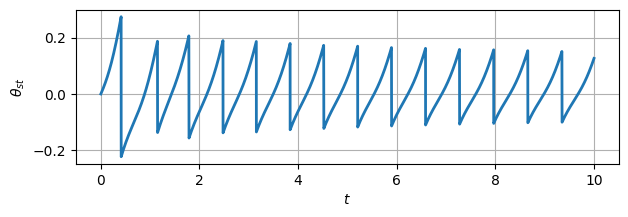

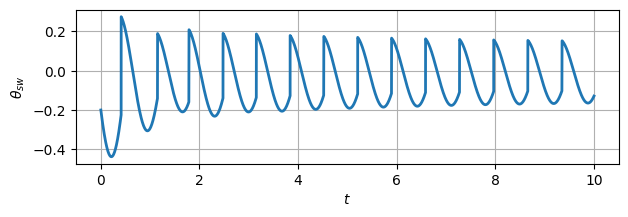

In [22]:
# Generate a valid initial condition using the reset map.
x0 = jnp.array([0.0, -0.2, 0.4, -2.0])
context = context.with_continuous_state(x0)

# Note we want to limit the major step length here to avoid skipping over the collision
options = SimulatorOptions(
    max_major_step_length=0.5,
    max_major_steps=400,
    atol=1e-14,
    rtol=1e-12,
)
recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
    "stance": model.output_ports[2],
}
results = collimator.simulate(
    model,
    context,
    (0.0, 10.0),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 0], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta_{st}$")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 1], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta_{sw}$")
ax.grid()
plt.show()

Again the trajectory settles down to a limit cycle after an initial transient

<Figure size 400x400 with 0 Axes>

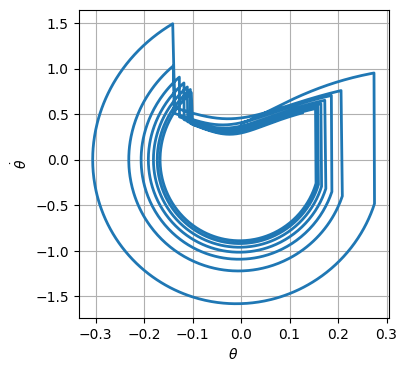

In [23]:
t = results.time
xc = results.outputs["xc"]
toe = results.outputs["toe"]
stance = results.outputs["stance"]
p = results.context.parameters

model.plot_trajectory(xc, stance)

In [24]:
try:
    # NOTE: You need IPython and ffmpeg installed to create the animation
    # also may need to point to your local ffmpeg path: `which ffmpeg`
    plt.rcParams["animation.ffmpeg_path"] = "/usr/local/bin/ffmpeg"

    model.animate(
        t, xc, toe, stance, p, xlim=(-1, 6), ylim=(-1.0, 1.5), dt=0.05, ramp_color="k"
    )

except:
    print(
        "Could not create animation.  Make sure ffmpeg is installed and available to matplotlib."
    )

#### Finding limit cycles
We use the same Shooting method as in previous examples to find a periodic solution.

In [25]:
model = CompassGait()
context = model.create_context()

Initialized callback CompassGait_5_:CompassGait_5__ode with prereqs [1, 2, 8]
Initialized callback CompassGait_5_:y_0 with prereqs [2]
Initialized callback CompassGait_5_:y_1 with prereqs [0]
Initialized callback CompassGait_5_:y_2 with prereqs [0]


In [26]:
# Define a function to compute the difference between the final and initial state
def shoot(model, context, unflatten, vec):
    xc0, tf = unflatten(vec)
    context = context.with_continuous_state(xc0)
    xd0 = model.DiscreteStateType(toe=0.0, left_leg_is_stance=False)
    context = context.with_discrete_state(xd0)

    # Run simulation
    options = SimulatorOptions(
        enable_autodiff=True,
        max_major_step_length=0.5,
        max_major_steps=400,
        atol=1e-14,
        rtol=1e-12,
    )
    results = collimator.simulate(model, context, (0.0, tf), options=options)
    xf = results.context.continuous_state
    return jnp.linalg.norm(xf - xc0) ** 2


tf0 = 0.7
vec, unflatten = ravel_pytree((x0, tf0))
shoot(model, context, unflatten, vec)

Array(0.24345888, dtype=float64)

In [27]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.4994656073092663e-13
        x: [-4.405e-02  7.271e-02  2.639e-01 -6.789e-01  7.013e-01]
      nit: 29
      jac: [-1.279e-06 -5.835e-07 -3.202e-08  3.239e-08  1.984e-07]
 hess_inv: [[ 9.188e-01 -7.605e-01 ...  7.022e+00  4.523e-01]
            [-7.605e-01  1.516e+00 ... -4.740e+00  5.446e-01]
            ...
            [ 7.022e+00 -4.740e+00 ...  9.353e+01  9.539e+00]
            [ 4.523e-01  5.446e-01 ...  9.539e+00  2.114e+00]]
     nfev: 34
     njev: 34

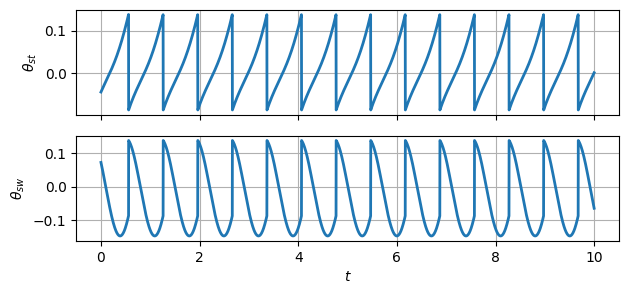

In [28]:
# Note we want to limit the major step length here to avoid skipping over the collision

options = SimulatorOptions(
    max_major_step_length=0.5,
    max_major_steps=400,
    atol=1e-14,
    rtol=1e-12,
)
context = context.with_continuous_state(x_opt)
xd = model.DiscreteStateType(toe=0.0, left_leg_is_stance=False)
context = context.with_discrete_state(xd)

recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
    "stance": model.output_ports[2],
}
results = collimator.simulate(
    model,
    context,
    (0.0, 10.0),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(t, x[:, 0], lw=2)
ax[0].set_ylabel(r"$\theta_{st}$")
ax[0].grid()

ax[1].plot(t, x[:, 1], lw=2)
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$\theta_{sw}$")
ax[1].grid()
plt.show()

The trajectory now starts and stays on the limit cycle. We can visualize the trajectory in the phase space.

<Figure size 400x400 with 0 Axes>

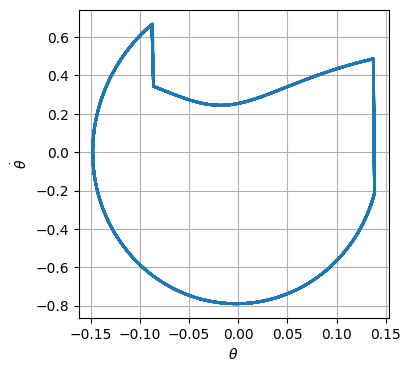

In [29]:
t = results.time
xc = results.outputs["xc"]
toe = results.outputs["toe"]
stance = results.outputs["stance"]
p = results.context.parameters

model.plot_trajectory(xc, stance)

#### Stability analysis
As with previous models, we can check the stability using Floquet theory.

In [30]:
def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
jac = jax.jacrev(func)(x_opt)

np.linalg.eigvals(jac)

array([-5.13253680e-01,  1.19392343e-15,  1.00000058e+00,  8.78664100e-01])